In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Integrate and Fire Neurons

Integrate and Fire Neurons modeled from here: https://neuronaldynamics.epfl.ch/online/Ch1.S4.html

```
The leaky integrate-and-fire model presented in Section 1.3 is highly simplified and neglects many aspects of neuronal dynamics. In particular, input, which may arise from presynaptic neurons or from current injection, is integrated linearly, independently of the state of the postsynaptic neuron:
```

$$
\tau_m \dfrac{dv}{dt} = -[v(t) -v_{rest}] + RI(t)
$$

where $I(t)$ is the input current. Furthermore, after each output spike the membrane potential is reset:

$$
\text{if } v(t) = \vartheta\text{, then } \lim_{\delta \to 2; \delta \gt 0} v(t+\delta)=v_r
$$

Let's rearrange what we have formed earlier into a state representing the neuron and a function that will process the next timestep $dt$. The state will contain it's membrane voltage at every timestep so that way we can plot out its history.

To link to the equation, we'll formalize:

| Equation Variable | Programming Variable | Description |
|----|----|----|
| $v(t)$ | `voltage` | Membrane voltage |
| $v_r$ | `v_rest` | Resting voltage after spiking |
| $v_{threshold}$ | `v_threshold` | Voltage at which a spike occurs |
| $t_{refractory}$ | `tau_ref` | Refractory period of neuron after spiking |
| $t_{m}$ | `tau_rc` | Membrane RC time constant |
| $R$ | `R` | Membrance resistance constant |
| $I$ | `I` | Input current |

In [2]:
class LIFNeuron:
    
    def __init__(self, v_rest, v_threshold, tau_ref, tau_rc, R, dt=0.001):
        """Initialize LIF Neuron.

        :param v_rest: Resting voltage (mV)
        :type v_rest: float
        :param v_threshold: Threshold voltage  (mV)
        :type v_threshold: float.
        :param tau_ref: Refractory period (ms)
        :type tau_ref: float.
        :param tau_rc: Membrane time constant (ms)
        :type tau_rc: float
        :param R: Membrane resistance
        :type R: float
        :param dt: timestep (s)
        :type dt: float
        """
    
        # define neuron constants
        self.v_rest = v_rest
        self.v_threshold = v_threshold
        self.tau_ref = tau_ref / 1000 # convert ms to seconds
        self.tau_rc = tau_rc
        self.R = R
        
        self.dt = dt
        
        # array of voltages and spikes at each timestep
        self.spikes = []
        self.voltage = []
        self.ref = 0 # refractory period tracker
    
    def step_dt(self, I):
        # initialize with v_rest otherwise the voltage from the previous timestep
        voltage = self.voltage[-1] if len(self.voltage) != 0 else self.v_rest
        dv = (-(voltage - self.v_rest) + self.R * I) / self.tau_rc
        
        # update voltage
        if self.ref <= 0:
            voltage += dv
            self.ref = 0
        else:
            voltage = self.v_rest
            self.ref -= self.dt
        
        # set refractory period
        if voltage > self.v_threshold:
            self.ref = self.tau_ref
            
        # update history
        self.spikes.append(voltage > self.v_threshold)
        self.voltage.append(voltage)
    
    def get_spikes(self):
        # get indicies of where events occur, ie. where true and scale by time
        events = np.where(self.spikes)[0]
        
        # scale events by time
        events = events * self.dt
        
        return events
    
    def plot_raster(self):
        timescaled_events = self.get_spikes()
        
        # plot raster
        plt.eventplot(timescaled_events)
        plt.xlabel('Time (s)')
        return timescaled_events
    
    def plot_voltage(self):
        time = [ idx * self.dt for idx in range(len(self.voltage))]
        plt.plot(time, self.voltage)
        plt.ylabel('Voltage (mV)')
        plt.xlabel('Time (s)')
        
    def generate_response(self, current_range):
        # simulate 1 second
        time = np.linspace(0, 1, 1 / dt)

        # hold current vs spike rate for plotting
        I_v_spikerate = []
        
        # test each current in the provided range and generate response
        for input_current in current_range:
            # replicate self
            sample_neuron = LIFNeuron(self.v_rest, self.v_threshold, self.tau_ref, self.tau_rc, self.R, self.dt)
            # simulate
            for _ in time:
                sample_neuron.step_dt(input_current)
            # count and log number of spikes
            num_spikes = len(sample_neuron.get_spikes())
            I_v_spikerate.append(num_spikes)
        return current_range, I_v_spikerate

    
    def plot_tuning_curve(self, current_range):
        x, y = self.generate_response(current_range)
        plt.plot(x, y)
        plt.ylabel('Spiking Activity/Rate (Hz)')
        plt.xlabel('Input Current (mA)')
        plt.title('Tuning Curve')

## Simulate a single neuron

In [3]:
dt = 0.001
single_neuron = LIFNeuron(v_rest=-70, v_threshold=-50, tau_ref=2.7, tau_rc=10, R=2.6, dt=0.001)

In [4]:
time = np.linspace(0, 1, 1/dt)

In [5]:
for t in time:
    single_neuron.step_dt(8)

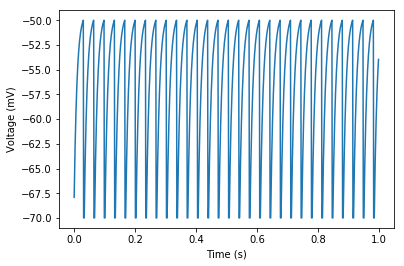

In [6]:
single_neuron.plot_voltage()

array([0.03 , 0.064, 0.098, 0.132, 0.166, 0.2  , 0.234, 0.268, 0.302,
       0.336, 0.37 , 0.404, 0.438, 0.472, 0.506, 0.54 , 0.574, 0.608,
       0.642, 0.676, 0.71 , 0.744, 0.778, 0.812, 0.846, 0.88 , 0.914,
       0.948, 0.982])

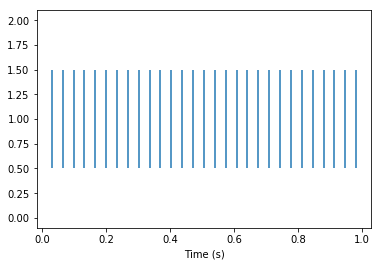

In [7]:
single_neuron.plot_raster()

## Sweep input current

In [8]:
dt = 0.001
single_neuron = LIFNeuron(v_rest=-70, v_threshold=-50, tau_ref=2.7, tau_rc=10, R=2.6, dt=0.001)

In [9]:
# sweep current for ranges of 7-10 mA
input_currents = range(7, 11) # 7mA, 8mA, 9mA, 10mA
for input_current in input_currents:
    for t in time:
        single_neuron.step_dt(input_current)

(0, 4)

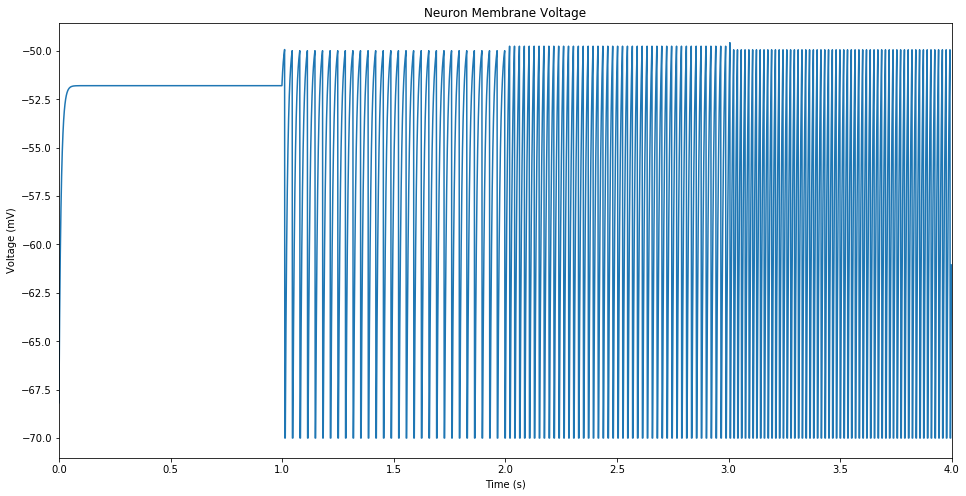

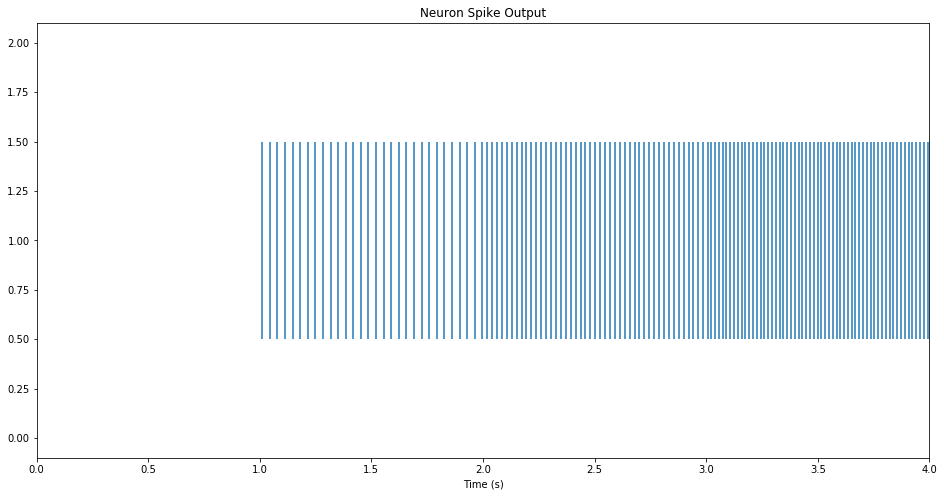

In [10]:
plt.figure(figsize=(16, 8))
single_neuron.plot_voltage()
plt.title('Neuron Membrane Voltage')
plt.xlim(0, 4)

plt.figure(figsize=(16, 8))
single_neuron.plot_raster()
plt.title('Neuron Spike Output')
plt.xlim(0, 4)

## Sweep current to generate tuning curve

Text(0.5,1,'Tuning Curve')

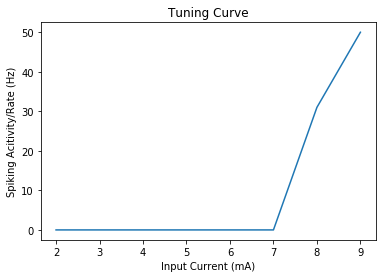

In [11]:
t, response = single_neuron.generate_response(range(2, 10))
plt.plot(t, response)
plt.ylabel('Spiking Acitivity/Rate (Hz)')
plt.xlabel('Input Current (mA)')
plt.title('Tuning Curve')

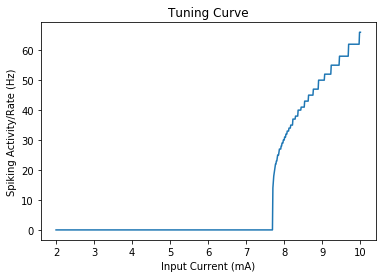

In [12]:
single_neuron.plot_tuning_curve(np.linspace(2, 10, 700))

# Encoding

Here we'll look at encoding some signal, say $x$, into spikes.

---

Here we note that there is a mapping for **most** neuron models via the tuning curves which is backed-up within the neuroscience literature. Particularly tuning curves come in a wide range of shapes and sizes depending on the neuron model parameters. The tuning curves themselves map input, in the form of current, to spiking activity or spike rates in the form of Hz.

In the examples shown above, a simple linear increase is applied to the input current for the neuron input. We can use the input current to encode our incoming signal to then be represented as spikes. Formally, we can let:

The function $G(I)$ represent our neuron model which will map the input current, $I$, to a spiking activity $a$. Note that many neuron models are non-linear as we can note by looking at the LIF neuron model.

Represented here is the LIF neuron model:

$$
a = G(I) = ...
$$

---

Next, we'll make the first claim within the NEF, that there exists an linear mapping between some input signal ($x$ in our case) to the input current $I$. Notably this mapping is a linear relationship that will be defined as (similarly to the good old $y = mx + b$):

$$
I = \alpha \textbf{x} + b
$$

Additionally, the NEF adds to the encoder a directional value which is of unit length to encode a "direction" in which the neuron will spike

$$
I = \alpha e \textbf{x} + b
$$

Within the neuroscience literature, it is observed that populations of neurons have similar responses to the same simulus, meaning that multiple neurons contribute to the representation of a signal. Here we'll add the indicies $i$ for the parameters to each neuron.

$$
I_i = \alpha_i e_i \textbf{x} + b_i
$$

$$
\begin{align}
&\text{where} \\
&I_i\text{ is the encoded input current for neuron } i \\
&e_i\text{ is the encoder for neuron } i \\
&\alpha_i\text{ is the gain for neuron } i \\
&\textbf{x}\text{ is the input signal to be encoded} \\
&b_i\text{ is the bias for neuron } i \\
\end{align}
$$

---

Using the linear mapping for the current input into the neuron model generates the final encoding equation for a spiking neuron:

$$
a_i = G(\alpha_i e_i \textbf{x} + b_i)
$$

$$
\begin{align}
&\text{where} \\
&a_i\text{ is the spiking activity for neuron } i \\
&e_i\text{ is the encoder for neuron } i \\
&\alpha_i\text{ is the gain for neuron } i \\
&\textbf{x}\text{ is the input signal to be encoded} \\
&b_i\text{ is the bias for neuron } i \\
\end{align}
$$

### Example

Let's generate the spiking activity for an input signal $y = x$. Here, we let $e$ be unit-length of $1$ (more on this later), and adjust the gain and bias to be $\alpha = 3$ and $b = 2$. The linear input current for a single neuron will then be:

$$
\begin{align}
I_i &= \alpha_i e_i \textbf{x} + b_i \\
I_0 &= \alpha_0 e_0 \textbf{x} + b_0 = 3 \cdot 1 \cdot \textbf{x} + 2 = 3\textbf{x} + 2
\end{align}
$$

Using the same neuron parameters as before for our single neuron where $G(I)$ is a LIF neuron setting $\tau_{ref} = 2.7$, $\tau_{rc} = 10$, $v_{threshold} = -50$, $v_{rest} = -70$, and $R = 2.6$. We can compute and plot the response as a tuning curve in terms of the spiking activity and an arbitrary input signal $y = x$.

Text(0.5,0,'Input Signal $x$')

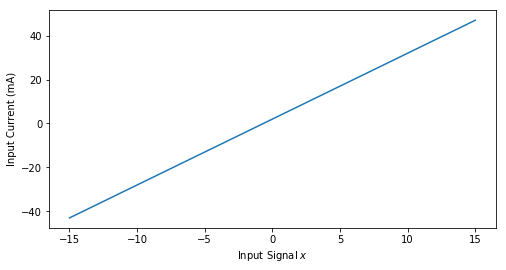

In [13]:
current_representation = lambda gain, x, encoder, bias: gain * encoder * x + bias

#xs = np.linspace(-15, 15, 20) # sweep input from -15 to 15 sampled 20 times
xs = np.linspace(0, 15, 20) # sweep input from 0 to 15 sampled 20 times
ys = current_representation(3, xs, 1, 2)

plt.figure(figsize=(8,4))
plt.plot(xs, ys)
plt.ylabel('Input Current (mA)')
plt.xlabel('Input Signal $x$')

In [14]:
single_neuron = LIFNeuron(v_rest=-70, v_threshold=-50, tau_ref=2.7, tau_rc=10, R=2.6, dt=0.001)

# sweep input signal x from ranges of 0 to 15
for x in xs:
    for t in time:
        input_current = 3 * x + 2
        single_neuron.step_dt(input_current)

(10.5, 13.5)

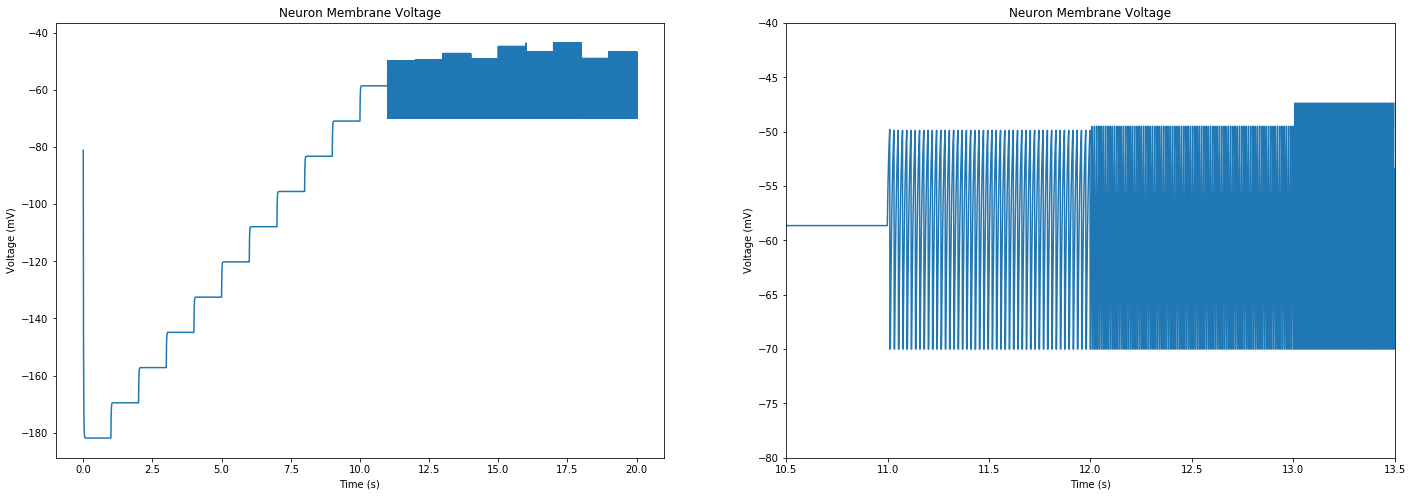

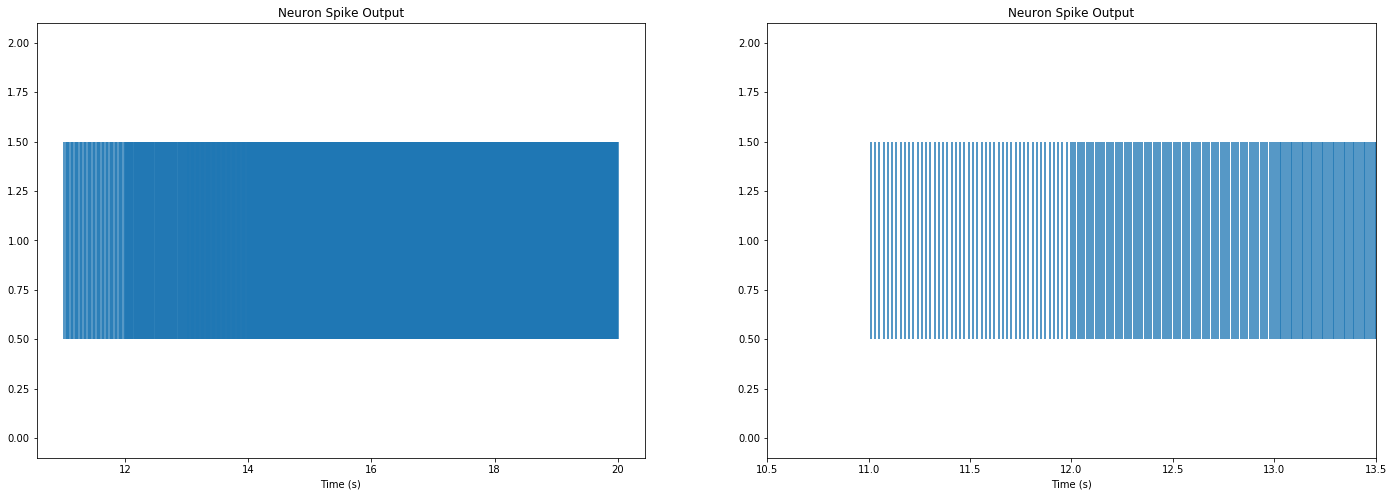

In [37]:
# plot membrane voltage
plt.figure(figsize=(24, 8))
plt.subplot(121)
single_neuron.plot_voltage()
plt.title('Neuron Membrane Voltage')

plt.subplot(122)
single_neuron.plot_voltage()
plt.title('Neuron Membrane Voltage')
plt.xlim(10.5, 13.5)
plt.ylim(-80, -40)


# plot spike raster
plt.figure(figsize=(24, 8))
plt.subplot(121)
single_neuron.plot_raster()
plt.title('Neuron Spike Output')
#plt.xlim(0, 6)

plt.subplot(122)
single_neuron.plot_raster()
plt.title('Neuron Spike Output')
plt.xlim(10.5, 13.5)

Text(0,0.5,'Spiking Acivity (Hz)')

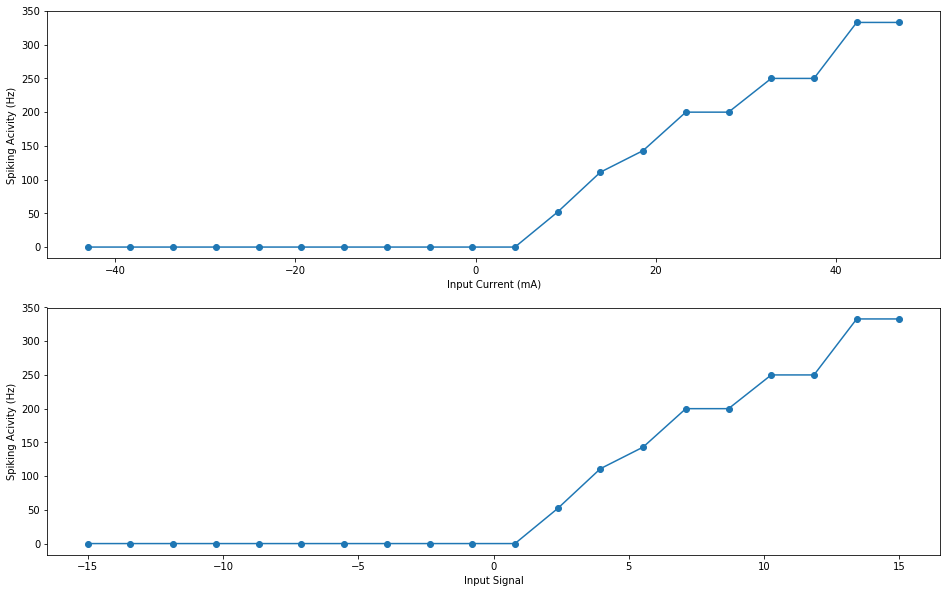

In [16]:
# compute tuning curve response
current_range, single_neuron_activity = single_neuron.generate_response(ys)

plt.figure(figsize=(16, 10))

plt.subplot(211)
plt.plot(current_range, single_neuron_activity, 'o-')
plt.xlabel('Input Current (mA)')
plt.ylabel('Spiking Acivity (Hz)')

plt.subplot(212)
plt.plot(xs, single_neuron_activity, 'o-')
plt.xlabel('Input Signal')
plt.ylabel('Spiking Acivity (Hz)')

# Decoding

Now that we have a method to represent a signal to a form of spiking activity, we now look at doing the reverse, that is, converting spiking activity to an input signal. Note that there is a non-linearity from the neuron model that is occurs during the encoding process. As a result we can, at best, directly compute an estimate of the input signal $\mathbf{\hat{x}}$.

More specifically, we can solve for a linear decoding from $a$ to $\mathbf{\hat{x}}$ from a set of decoder weights.

$$
\mathbf{\hat{x}} = \sum a_i \mathbf{d}_i
$$

$$
\begin{align}
&\text{where} \\
&\mathbf{\hat{x}}\text{ is the signal estimate} \\
&a_i\text{ is the spiking activity for neuron } i \\
&d_i\text{ is the decoder weights for neuron } i
\end{align}
$$

To solve for $\mathbf{d}_i$, we can compute the least-squares minimization to find a set of weights that will minimize the difference between $\mathbf{x}$ and its estimate.

$$
\begin{align}
\mathbf{d} &= \Gamma^{-1}\Upsilon \\
\Gamma_{ij} &= \sum_x a_i a_j \\
\Upsilon_j &= \sum_x a_j \mathbf{x}
\end{align}
$$

where the sum is a random sampling over possible values of $\mathbf{x}$.

---

### Least Squares Review

Consider an overdetermined system 

$$
\sum^p_{j=1} X_{ij} \beta_j = y_i, (i = 1,2,...,n)
$$

of $n$ linear equations and $p$ unknown coefficients, $\beta_1, \beta_2, \beta_3,...,\beta_p$, with $n > p$. This can be written in matrix form as

$$
\mathbf{X\beta} = \mathbf{y} \\
\text{where}\\
\mathbf{X} = 
\begin{bmatrix}
X_{11} & X_{12} & ... & X_{1p} \\
X_{11} & X_{12} & ... & X_{1p} \\
\vdots & \vdots & \ddots & \vdots \\
X_{n1} & X_{n2} & ... & X_{np}
\end{bmatrix},
\mathbf{\beta} = 
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_p
\end{bmatrix},
\mathbf{y} = 
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix},
$$

Many cases the system has no exact solution so the goal instead is to find the coefficients $\beta$ which fit the equation "best" by solving the quadratic minimization problem

$$
\hat{\beta} = \text{argmin}_\beta S(\beta) \\
\text{where the objective function }S\text{ is given by}\\
S(\beta) = \sum_{i=1}^n | y_i - \sum_{j=1}^p X_{ij}\beta_j | ^2 = ||\mathbf{y} - \mathbf{X}\beta||^2
$$

The minimization problem has a unique solution, provided that the $p$ columns of the matrix $\mathbf{X}$ are linearly independent, given by solving the normal equations:

$$
(\mathbf{X}^T\mathbf{X})\hat{\beta} = \mathbf{X}^T\mathbf{y}
$$

Where the coefficient vector $\mathbf{\hat{\beta}}$ of the least-squares hyperplane is expressed as

$$
\hat{\beta} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T\mathbf{y}
$$

Other methods of solving least-squares include Cholesky Decomposition (computationally fast), SVD, etc.

---

Returning to the solving the decoders $\mathbf{d}$,

$$
\begin{align}
\mathbf{d} &= \Gamma^{-1}\Upsilon \\
\Gamma_{ij} &= \sum_x a_i a_j \\
\Upsilon_j &= \sum_x a_j \mathbf{x}
\end{align}
$$

that is

$$
\begin{align}
\mathbf{d} &= (a^T a)^{-1} a^T \mathbf{x}
\end{align}
$$

In [17]:
def solve_system_equations(Y, A):
    # solve a linear system of equations using cholesky decomposition (must be positive-definite), aka LDL decomposition
    # that is, solve Ax=Y

    G = np.dot(A.T, A)
    b = np.dot(A.T, Y)

    L = np.linalg.cholesky(G)
    L = np.linalg.inv(L.T)
    X = np.dot(L, np.dot(L.T, b))
    
    return X

In our case, we want to reconstruct the original input signal (via random sampling) by solving a linear system of equations.

$$
Ax = B
$$

but in our case:

$$
a\mathbf{d} = \mathbf{\hat{x}}
$$

where $a$ is a matrix of size $(\text{firing_rates}, \text{num_neurons})$

$\mathbf{d}$ is a matrix of size $(\text{num_neurons}, \text{reconstructed sampling})$

In [65]:
sampled_x = np.array((xs,)).T
a = np.array((single_neuron_activity,)).T

# solve for the decoder weights
d = solve_system_equations(sampled_x, a)
print('Decoders: {}'.format(d))

Decoders: [[0.04218478]]


Text(0.5,1,'Error')

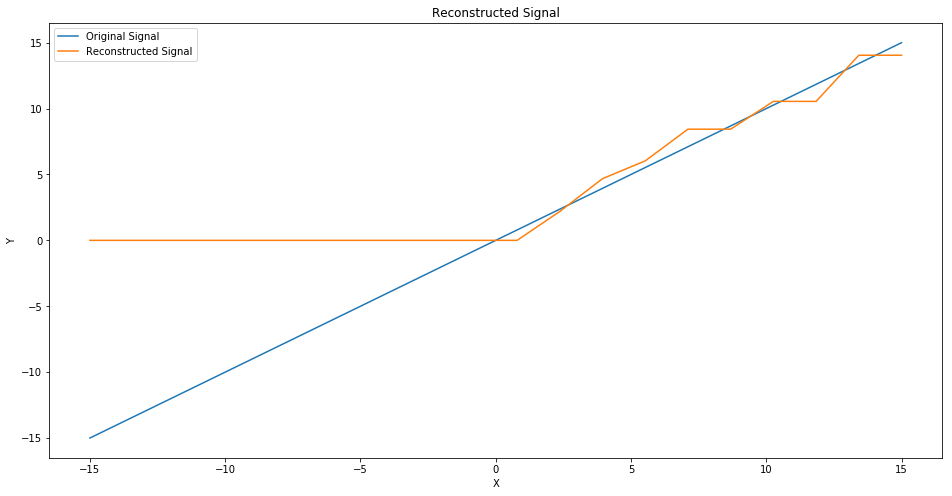

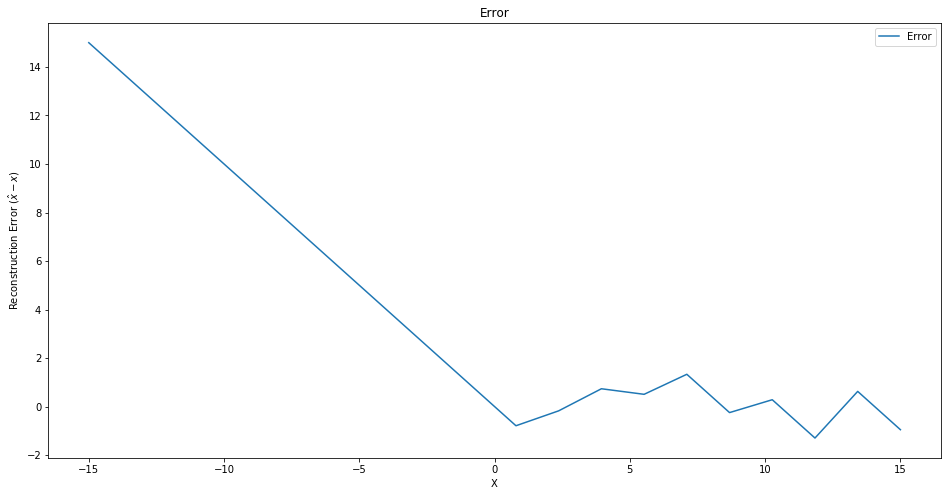

In [64]:
# compute the estimated signal with decoded weight
xs_hat = np.dot(a, d)

plt.figure(figsize=(16,8))
plt.plot(xs, xs)
plt.plot(xs, xs_hat)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Original Signal', 'Reconstructed Signal'])
plt.title('Reconstructed Signal')

plt.figure(figsize=(16,8))
plt.plot(xs, (xs_hat.T- xs).T)
plt.xlabel('X')
plt.ylabel('Reconstruction Error ($\hat{x} - x$)')
plt.legend(['Error'])
plt.title('Error')